Ex. 1. Se doreşte modelarea probabilităţii ca un student să promoveze un examen în funcţie de numărul de
ore de studiu pe săptămână. Datele sintetice arată astfel:

ore de studiu:    1 3 4 5 6 8

promovare (0/1): 0 0 1 1 1 1

Construiţi un model bayesian de regresie logistică care:

a) să estimeze coeficienţii regresiei (interceptul şi panta), probabilitatea de mai sus şi frontiera de decizie;

b) să ofere intervale de credibilitate (HDI) pentru frontiera de decizie.

Output()

Output()

ERROR:pymc.stats.convergence:There were 758 divergences after tuning. Increase `target_accept` or reparameterize.
/usr/local/lib/python3.10/dist-packages/arviz/plots/hdiplot.py:161: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


     mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
α   4.583  2.419   0.276    9.367      0.109    0.079     496.0     493.0   
β   5.249  2.068   1.537    8.858      0.113    0.082     316.0     449.0   
bd -0.905  1.020  -1.758    0.037      0.032    0.023     947.0     996.0   

    r_hat  
α    1.00  
β    1.01  
bd   1.00  


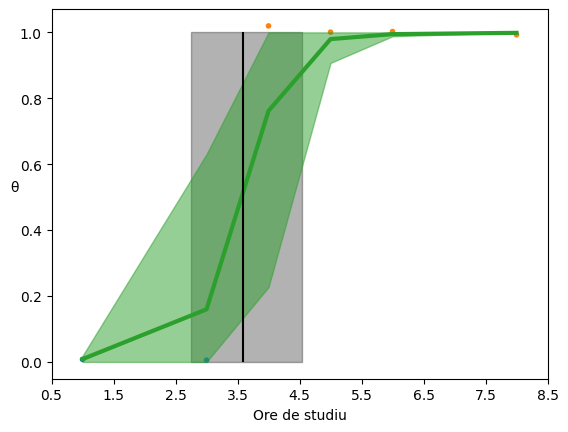

In [ ]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

# (a)
ore_studiu = np.array([1, 3, 4, 5, 6, 8])
promovare = np.array([0, 0, 1, 1, 1, 1])

#centrare date
x_c = ore_studiu - np.mean(ore_studiu)

with pm.Model() as model_0:
  α = pm.Normal('α', mu=0, sigma=10) #interceptul
  β = pm.Normal('β', mu=0, sigma=10) #panta

  μ = α + pm.math.dot(x_c, β)
  θ = pm.Deterministic('θ', pm.math.sigmoid(μ)) #probabilitatile
  bd = pm.Deterministic('bd', -α/β)

  yl = pm.Bernoulli('yl', p=θ, observed=promovare)
  idata = pm.sample(1000, return_inferencedata=True)

  print(az.summary(idata, var_names=['α', 'β', 'bd']))

  posterior_0 = idata.posterior.stack(samples=("chain", "draw"))
  theta = posterior_0['θ'].mean("samples")
  idx = np.argsort(x_c)

  #prob. medie de promovare stiind ca a studiat x ore
  plt.plot(x_c[idx], theta[idx], color='C2', lw=3)
  plt.vlines(posterior_0['bd'].mean(), 0, 1, color='k') #frontiera
  bd_hpd = az.hdi(posterior_0['bd'].values)
  plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='k', alpha=0.3)
  plt.scatter(x_c, np.random.normal(promovare, 0.02),marker='.', color=[f'C{x}' for x in promovare])

  az.plot_hdi(x_c, posterior_0['θ'].T, color='C2', smooth=False) #hdi pt θ
  plt.xlabel('Ore de studiu')
  plt.ylabel('θ', rotation=0)

  locs, _ = plt.xticks()
  plt.xticks(locs, np.round(locs + ore_studiu.mean(), 1)) #etichete axa x, reale

Ex. 2. Ce factori determină admiterea la facultate în Statele Unite? În fişierul Admission.csv au fost strânse
datele a 400 de cazuri de admitere la o facultate. “Admission” este un răspuns binar, cu 1 sau 0 indicând
“admis”, respectiv “respins”. Sunt de asemenea disponibile scorul la testul GRE şi rezultatul mediu din liceu,
GPA (undergraduate grade point average). Fie pi probabilitatea ca studentul cu nr. i să fie admis.
Considerăm modelul logistic

pi = logistic(β0 + β1xi1 + β2xi2),

unde xi1 şi xi2 sunt scorul GRE, respectiv GPA pentru studentul i.

a) Folosind distribuţii a priori slab informative asupra parametrilor β0, β1 şi β2, folosiţi PyMC pentru a simula un eşantion suficient de mare (construi modelul) din distribuţia a posteriori.

b) Care este, în medie, graniţa de decizie pentru acest model? Reprezentaţi de asemenea grafic o zonă în jurul acestei grafic care să reprezinte un interval 94% HDI.

c) Să presupunem că un student are un scor GRE de 550 şi un GPA de 3.5. Construiţi un interval de 90% HDI pentru probabilitatea ca acest student să fie admis.

d) Dar dacă studentul are un scor GRE de 500 şi un GPA de 3.2? (refaceţi exerciţiul anterior cu aceste date) Cum justificaţi diferenţa?

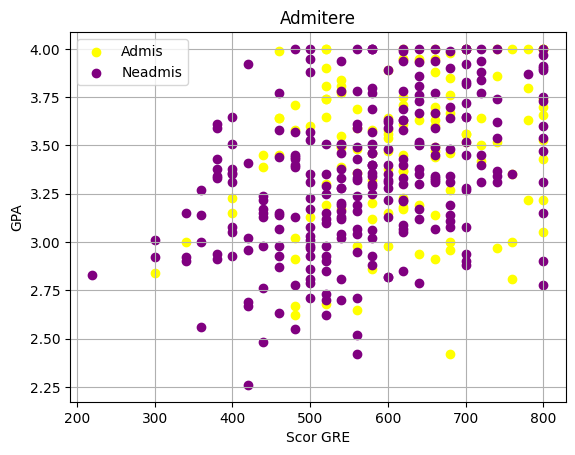

Output()

Output()

<ipython-input-15-fd1d1936700d>:59: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  interval_hdi = az.hdi(frontiere, hdi_prob=0.94)


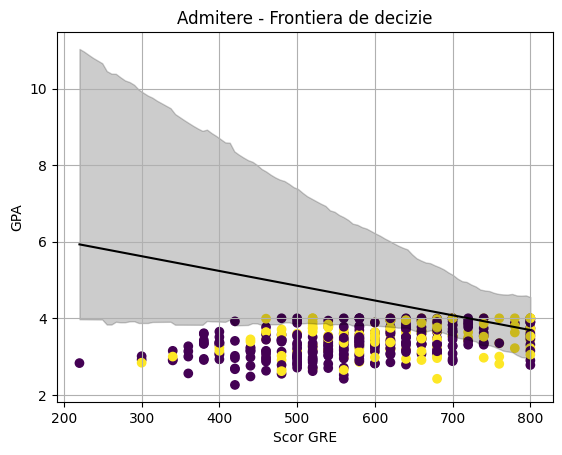

In [15]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

data = pd.read_csv("Admission.csv")

gre_data = data["GRE"].values
gpa_data = data["GPA"].values
y_admission = data["Admission"].values

#vizualizare initiala date
plt.scatter(gre_data[y_admission==1], gpa_data[y_admission==1], color='yellow', label='Admis')
plt.scatter(gre_data[y_admission==0], gpa_data[y_admission==0], color='purple', label='Neadmis')
plt.xlabel("Scor GRE")
plt.ylabel("GPA")
plt.title("Admitere")
plt.legend()
plt.grid(True)
plt.show()

# (a)
#standardizare date
medie_gre_data, std_gre_data = gre_data.mean(axis=0), gre_data.std(axis=0)
medie_gpa_data, std_gpa_data = gpa_data.mean(axis=0), gpa_data.std(axis=0)

gre_data_st = (gre_data - medie_gre_data) / std_gre_data #xi1
gpa_data_st = (gpa_data - medie_gpa_data) / std_gpa_data #xi2

with pm.Model() as model:
    beta0 = pm.Normal("beta0", mu=0, sigma=10)
    beta1 = pm.Normal("beta1", mu=0, sigma=10)
    beta2 = pm.Normal("beta2", mu=0, sigma=10)

    μ = beta0 + beta1 * gre_data_st + beta2 * gpa_data_st
    θ = pm.Deterministic('μ', pm.math.sigmoid(μ)) #pi = logistic(β0 + β1xi1 + β2xi2),

    y_obs = pm.Bernoulli("y_obs", p=θ, observed=y_admission)
    trace = pm.sample(2000, tune=1000, target_accept=0.9)

# esantioanele posterioare
esantion_beta0 = trace.posterior["beta0"].values.flatten()
esantion_beta1 = trace.posterior["beta1"].values.flatten()
esantion_beta2 = trace.posterior["beta2"].values.flatten()

# (b)
gre_values = np.linspace(gre_data.min(), gre_data.max(), 100)
gre_values_st = (gre_values - medie_gre_data) / std_gre_data

frontiere = []
for b0, b1, b2 in zip(esantion_beta0, esantion_beta1, esantion_beta2):
    frontiera_gpa_st = -(b0 + b1 * gre_values_st) / b2
    frontiera_gpa = frontiera_gpa_st * std_gpa_data + medie_gpa_data
    frontiere.append(frontiera_gpa)
frontiere = np.array(frontiere)

frontiera_medie = np.mean(frontiere, axis=0)
interval_hdi = az.hdi(frontiere, hdi_prob=0.94)


plt.scatter(gre_data, gpa_data, c=y_admission)
plt.plot(gre_values, frontiera_medie, color='k')
plt.fill_between(gre_values, interval_hdi[:, 0], interval_hdi[:, 1], color='k', alpha=0.2)
plt.xlabel("Scor GRE")
plt.ylabel("GPA")
plt.title("Admitere - Frontiera de decizie")
plt.grid(True)
plt.show()

In [14]:
def get_admission_prob(gre1, gpa1, medie_gre_data, std_gre_data, medie_gpa_data, std_gpa_data):
    #standardizare date
    gre_st = (gre1 - medie_gre_data) / std_gre_data
    gpa_st = (gpa1 - medie_gpa_data) / std_gpa_data

    p = esantion_beta0 + esantion_beta1 * gre_st + esantion_beta2 * gpa_st
    p_i = 1 / (1 + np.exp(-p))

    print(f"Probabilitatea de admitere: {np.mean(p_i):.2f}")
    print(az.hdi(np.array(p_i), hdi_prob=0.90))

# (c)
gre1 = 550
gpa1 = 3.5
get_admission_prob(gre1, gpa1, medie_gre_data, std_gre_data, medie_gpa_data, std_gpa_data)

# (d)
gre2 = 500
gpa2 = 3.2
get_admission_prob(gre2, gpa2, medie_gre_data, std_gre_data, medie_gpa_data, std_gpa_data)

Probabilitatea de admitere: 0.30
[0.25770171 0.3460448 ]
Probabilitatea de admitere: 0.23
[0.18550894 0.27687593]
